In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
x0 = np.array([0.5, 0])
h0 = 0.2

In [3]:
def exact_solution(k, x0):
    def f(x):
        dist = np.linalg.norm(x - x0, axis=1)
        return 1j / 4 * hankel1(0, k * dist)
    return f

# Sphere

In [4]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
# mesh = generate_mesh(a0, a1, b0, b1, shape)
mesh = fd.Mesh(shape + str(0) + ".msh")

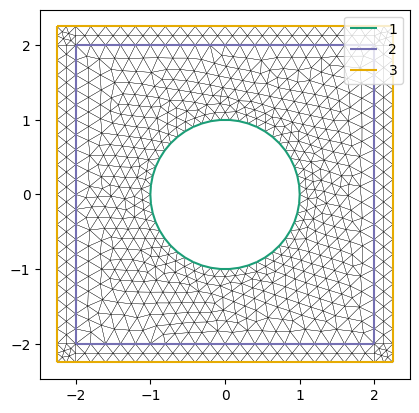

In [5]:
plot_mesh(mesh)

In [6]:
omega = 250
k = omega / c
g_data = exact_solution(k, x0)
uh = solve(mesh, k, a1, b1, g_data)

Exact solution:


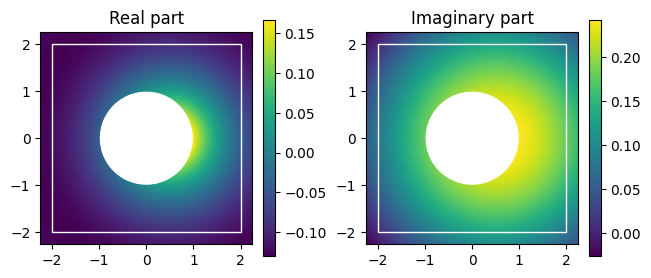

In [7]:
W = fd.VectorFunctionSpace(mesh, "CG", 1)
u = interpolate(W, exact_solution(k, x0))
print("Exact solution:")
plot_field(u, a0, a1, b0, b1)

Numerical solution:


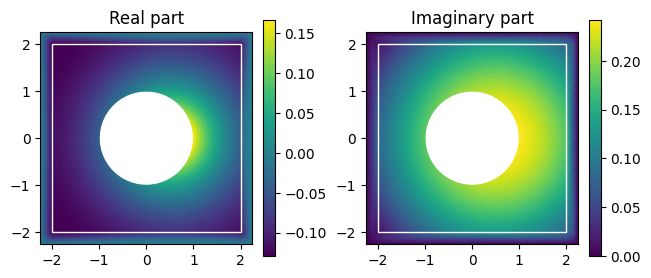

In [8]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [9]:
rel_err = compute_error(u, uh)
print(f"Relative error {rel_err:.2%}")

Relative error 1.25%


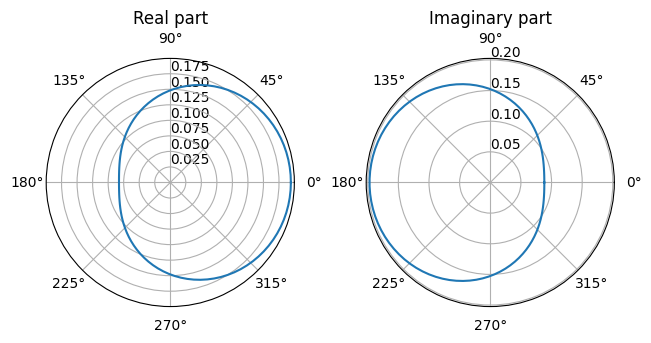

In [10]:
plot_far_field(k, uh)

In [11]:
# Convergence
max_level = 5
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [12]:
mesh_hierarchy = []
for level in levels:
    # mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, level))
    mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))

angular freqency = 250
refinement level 0, relative error 1.25%
refinement level 1, relative error 0.87%
refinement level 2, relative error 0.49%
refinement level 3, relative error 0.18%
refinement level 4, relative error 0.08%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.34%
refinement level 1, relative error 0.96%
refinement level 2, relative error 0.49%
refinement level 3, relative error 0.35%
refinement level 4, relative error 0.15%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.72%
refinement level 1, relative error 1.19%
refinement level 2, relative error 0.45%
refinement level 3, relative error 0.21%
refinement level 4, relative error 0.12%
----------------------------------------


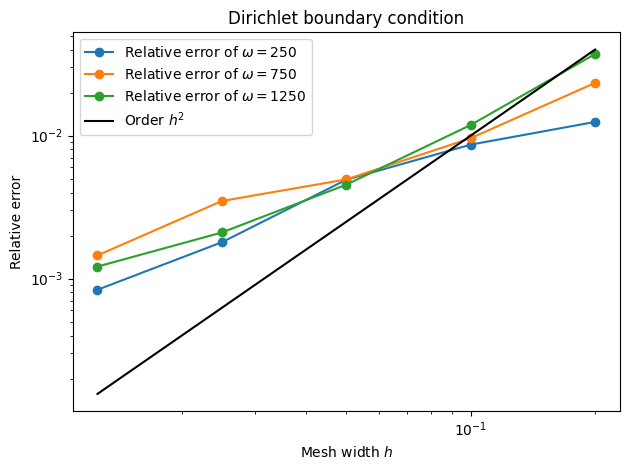

In [13]:
# Dirichlet problem
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = exact_solution(k, x0)
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        W = fd.VectorFunctionSpace(m, "CG", 1)
        u = interpolate(W, exact_solution(k, x0))
        uh = solve(m, k, a1, b1, g_fct, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.21%
refinement level 1, relative error 1.02%
refinement level 2, relative error 0.54%
refinement level 3, relative error 0.22%
refinement level 4, relative error 0.10%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.13%
refinement level 1, relative error 0.90%
refinement level 2, relative error 0.52%
refinement level 3, relative error 0.38%
refinement level 4, relative error 0.15%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.28%
refinement level 1, relative error 1.07%
refinement level 2, relative error 0.44%
refinement level 3, relative error 0.21%
refinement level 4, relative error 0.13%
----------------------------------------


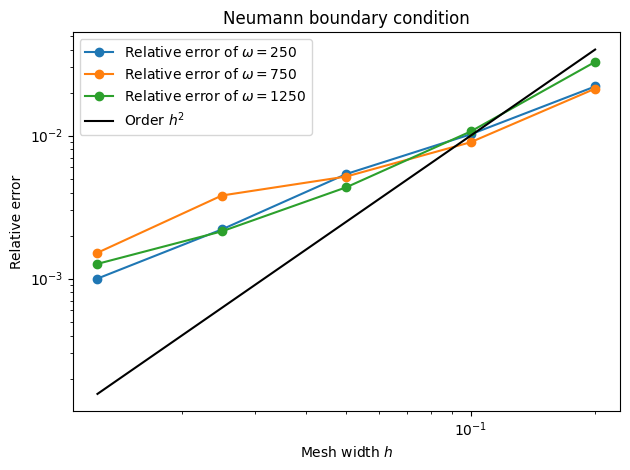

In [14]:
# Neumann problem
def neumann_bc(k, x0):
    def f(x):
        dist = np.linalg.norm(x - x0, axis=1)
        return -1j / 4 * hankel1(1, k * dist) * k / dist \
               * np.einsum("ij,ij->i", x - x0, -x)
    return f

neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = neumann_bc(k, x0)
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        W = fd.VectorFunctionSpace(m, "CG", 1)
        u = interpolate(W, exact_solution(k, x0))
        uh = solve(m, k, a1, b1, g_fct, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
beta 0.1, relative error 76.81%
beta 0.2, relative error 41.67%
beta 0.3, relative error 19.08%
beta 0.4, relative error 19.53%
beta 0.5, relative error 15.03%
beta 0.6, relative error 6.41%
beta 0.7, relative error 2.43%
beta 0.8, relative error 1.25%
beta 0.9, relative error 1.04%
beta 1.0, relative error 1.02%
beta 1.1, relative error 1.63%
beta 1.2, relative error 3.81%
beta 1.3, relative error 8.15%
beta 1.4, relative error 15.02%
beta 1.5, relative error 24.14%
beta 1.6, relative error 34.35%
beta 1.7, relative error 44.13%
beta 1.8, relative error 52.49%
beta 1.9, relative error 59.23%
beta 2.0, relative error 64.61%
beta 2.1, relative error 68.94%
beta 2.2, relative error 72.52%
beta 2.3, relative error 75.53%
beta 2.4, relative error 78.13%
beta 2.5, relative error 80.39%
beta 2.6, relative error 82.38%
beta 2.7, relative error 84.15%
beta 2.8, relative error 85.73%
beta 2.9, relative error 87.15%
beta 3.0, relative error 88.44%
-------------------------

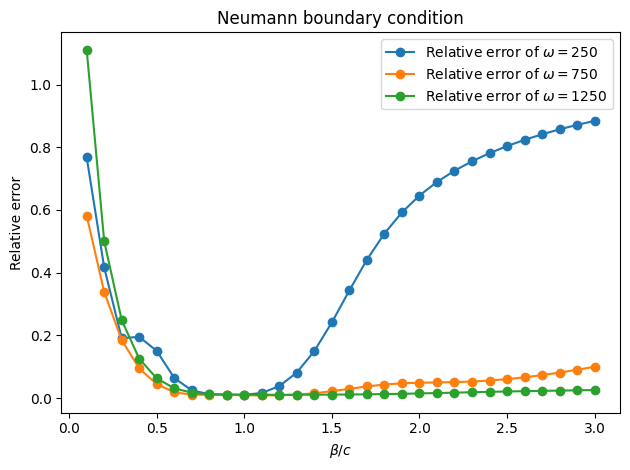

In [15]:
neumann = True
m = mesh_hierarchy[1]
betas = np.linspace(0.1, 3, 30)
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = neumann_bc(k, x0)
    W = fd.VectorFunctionSpace(m, "CG", 1)
    u = interpolate(W, exact_solution(k, x0))
    errors = []
    for beta in betas:
        uh = solve(m, k, a1, b1, g_fct, neumann, beta=beta)
        rel_err = compute_error(u, uh)
        print(f"beta {beta:.2}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.plot(betas, errors, "-o",
             label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.legend()
plt.xlabel(r"$\beta / c$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Kite

In [16]:
shape = "kite"
a0 = b0 = 2.0
a1 = b1 = 2.25
# mesh = generate_mesh(a0, a1, b0, b1, shape)
mesh = fd.Mesh(shape + str(0) + ".msh")

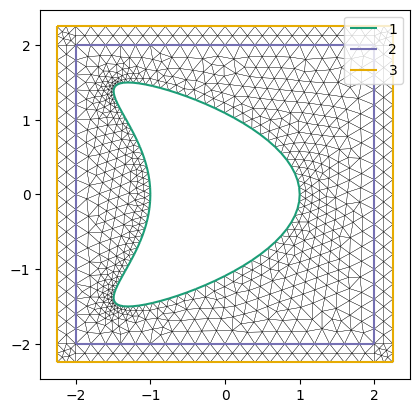

In [17]:
plot_mesh(mesh)

In [18]:
omega = 250
k = omega / c
g_data = exact_solution(k, x0)
uh = solve(mesh, k, a1, b1, g_data)

Exact solution:


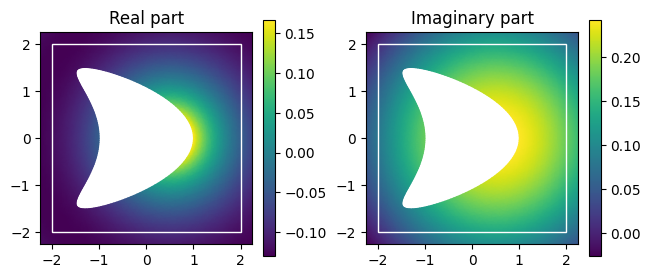

In [19]:
W = fd.VectorFunctionSpace(mesh, "CG", 1)
u = interpolate(W, exact_solution(k, x0))
print("Exact solution:")
plot_field(u, a0, a1, b0, b1)

Numerical solution:


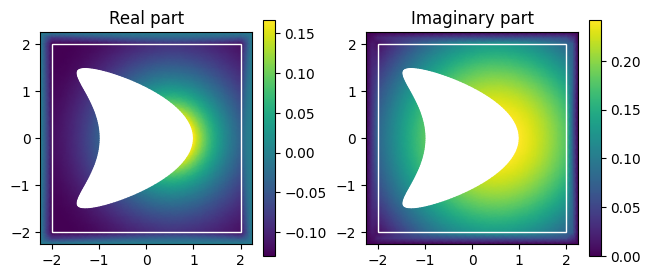

In [20]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [21]:
rel_err = compute_error(u, uh)
print(f"Relative error {rel_err:.2%}")

Relative error 1.31%


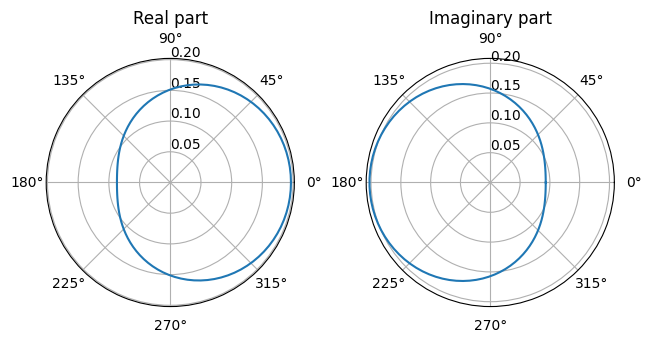

In [22]:
plot_far_field(k, uh)

In [23]:
# Convergence
max_level = 5
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [24]:
mesh_hierarchy = []
for level in levels:
    # mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, level))
    mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))

angular freqency = 250
refinement level 0, relative error 1.31%
refinement level 1, relative error 0.73%
refinement level 2, relative error 0.52%
refinement level 3, relative error 0.18%
refinement level 4, relative error 0.08%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.21%
refinement level 1, relative error 0.89%
refinement level 2, relative error 0.47%
refinement level 3, relative error 0.35%
refinement level 4, relative error 0.15%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.50%
refinement level 1, relative error 1.13%
refinement level 2, relative error 0.45%
refinement level 3, relative error 0.21%
refinement level 4, relative error 0.12%
----------------------------------------


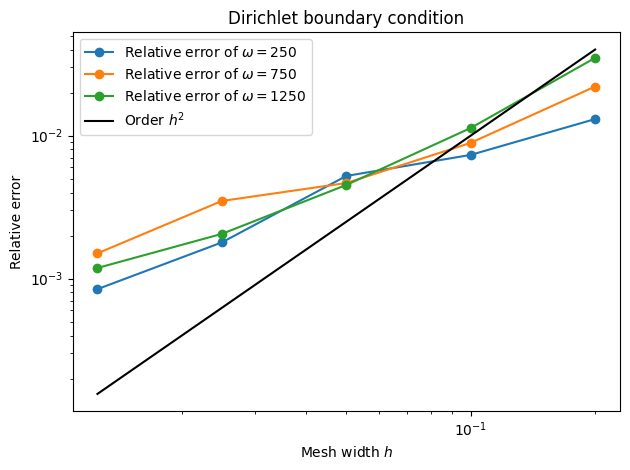

In [25]:
# Dirichlet problem
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = exact_solution(k, x0)
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        W = fd.VectorFunctionSpace(m, "CG", 1)
        u = interpolate(W, exact_solution(k, x0))
        uh = solve(m, k, a1, b1, g_fct, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

In [26]:
import finat
x = np.array([[0.0, 0.0],
              [1.0, 0.0],
              [0.0, 1.0]])
w = np.arange(3, dtype=np.float64)
w[:] = 1.0/3.0
x = finat.point_set.PointSet(x)
quad_rule = finat.quadrature.QuadratureRule(x, w)